title

data wrangling

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import functools
import math


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import BallTree

In [2]:
animetable = pd.read_csv('anime.csv')
print(animetable.shape) # so there are 12k anime/manga, etc. and 7 attributes
animetable.head() # note in tutorial: starting out, probaby better to print out more, which you can do by 
# sampling() function or just typing in the dataframe. the dataframe will be printed out
# for ease of reading, we'll just use head to show the first five elements in dataframe

(12294, 7)


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [3]:
animetable.isnull().sum()# how many null values do we have? maybe explain why we need to clean up null values

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [4]:
print (animetable[animetable.rating.isnull()].shape)
animetable[animetable.rating.isnull()].head()

(230, 7)


,anime_id,name,genre,type,episodes,rating,members
8968,34502,Inazma Delivery,"Action, Comedy, Sci-Fi",TV,10,NaN,32
9657,34309,Nananin no Ayakashi: Chimi Chimi Mouryou!! Gen...,"Comedy, Supernatural",TV,Unknown,NaN,129
10896,34096,Gintama (2017),"Action, Comedy, Historical, Parody, Samurai, S...",TV,Unknown,NaN,13383
10897,34134,One Punch Man 2,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ...",TV,Unknown,NaN,90706
10898,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,NaN,60999


We are removing anything without a rating. A general glance through this list, this seems to be everything without a rating hadn't aired when this dataset was created. Thus, because we will later use the ratings for ML analysis, we are throwing out these values, and saying that we are only analyzing anime from pre-2017. Ok, these don't have the years on them, but we are weebs so we can tell. trust us

In [5]:
animetable = animetable.dropna(subset=['rating'])

In [6]:
animetable.isnull().sum()

anime_id     0
name         0
genre       47
type         0
episodes     0
rating       0
members      0
dtype: int64

In [7]:
print (animetable[animetable.genre.isnull()].shape)
animetable[animetable.genre.isnull()].head()

(47, 7)


,anime_id,name,genre,type,episodes,rating,members
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607


Throwing out the instances without genres as well. There are only a few, with generally low interest, and we still have a lot of data to consider

In [8]:
animetable = animetable.dropna(subset=['genre'])

In [9]:
#temporary measure: populate anything with unknown as 1 episode
print(animetable[animetable.episodes == 'Unknown'].shape)
animetable[animetable.episodes == 'Unknown'].head()

(187, 7)


,anime_id,name,genre,type,episodes,rating,members
74,21,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",TV,Unknown,8.58,504862
252,235,Detective Conan,"Adventure, Comedy, Mystery, Police, Shounen",TV,Unknown,8.25,114702
615,1735,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,Unknown,7.94,533578
991,966,Crayon Shin-chan,"Comedy, Ecchi, Kids, School, Shounen, Slice of...",TV,Unknown,7.73,26267
1021,33157,Tanaka-kun wa Itsumo Kedaruge Specials,"Comedy, School, Slice of Life",Special,Unknown,7.72,5400


In [10]:
animetable.episodes = animetable.episodes.replace(['Unknown'], 1)

In [11]:
# now that we've gotten rid of null/ unknown values, let's turn some of our data into quantitative values
animetable.episodes = animetable.episodes.astype(int)
animetable.rating = animetable.rating.astype(float)
animetable.members = animetable.members.astype(int)

In [12]:
ratingtable = pd.read_csv('rating.csv')
ratingtable.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [13]:
#running this cell will make you cry for 30 minutes <- lol please keep this comment
# https://towardsdatascience.com/12-situations-data-scientists-will-totally-relate-to-bb6bd3f0a28e lol the closest thing i could find

animetable['unrated'] = animetable.anime_id.apply(lambda x: ratingtable[
    (ratingtable['anime_id'] == x) & (ratingtable['rating']==-1)].shape[0])
animetable['rated'] = animetable.anime_id.apply(lambda x: ratingtable[
    (ratingtable['anime_id'] == x) & (ratingtable['rating']!=-1)].shape[0])
animetable.head()

,anime_id,name,genre,type,episodes,rating,members,unrated,rated
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,238,1961
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,3080,21494
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,198,1188
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,2132,17151
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,558,3115


let's do some data viz
start out with visualizing the genres represented in our dataset

In [14]:
# splitting the genre table, so each one is an attribute. explain why this needs to be done?
animetable.genre = animetable.genre.apply(lambda x: x.split(', '))
animetable['genreCount'] = animetable.genre.apply(lambda x: len(x))

In [15]:
genre_list = list(itertools.chain.from_iterable(animetable.genre.values.flatten()))
genre = np.unique(genre_list)
print(len(genre))
genre

43


array(['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons',
       'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai',
       'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts',
       'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police',
       'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen',
       'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai', 'Slice of Life',
       'Space', 'Sports', 'Super Power', 'Supernatural', 'Thriller',
       'Vampire', 'Yaoi', 'Yuri'], 
      dtype='<U13')

In [16]:
genre_count = []

for category in genre: 
    genre_count.append(genre_list.count(category))
    
dict = {'genre': genre, 'count':genre_count}
genre_df = pd.DataFrame(dict) # constructing a dataframe for plotting number of content vs genre

In [17]:
animetable.head()

,anime_id,name,genre,type,episodes,rating,members,unrated,rated,genreCount
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,238,1961,4
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64,9.26,793665,3080,21494,7
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51,9.25,114262,198,1188,7
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",TV,24,9.17,673572,2132,17151,2
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51,9.16,151266,558,3115,7


In [18]:
genre_df.sort_values(by = "count", ascending = False)

,count,genre
3,4575,Comedy
0,2768,Action
1,2316,Adventure
8,2242,Fantasy
28,2036,Sci-Fi
6,1977,Drama
32,1684,Shounen
15,1598,Kids
25,1437,Romance
34,1204,Slice of Life


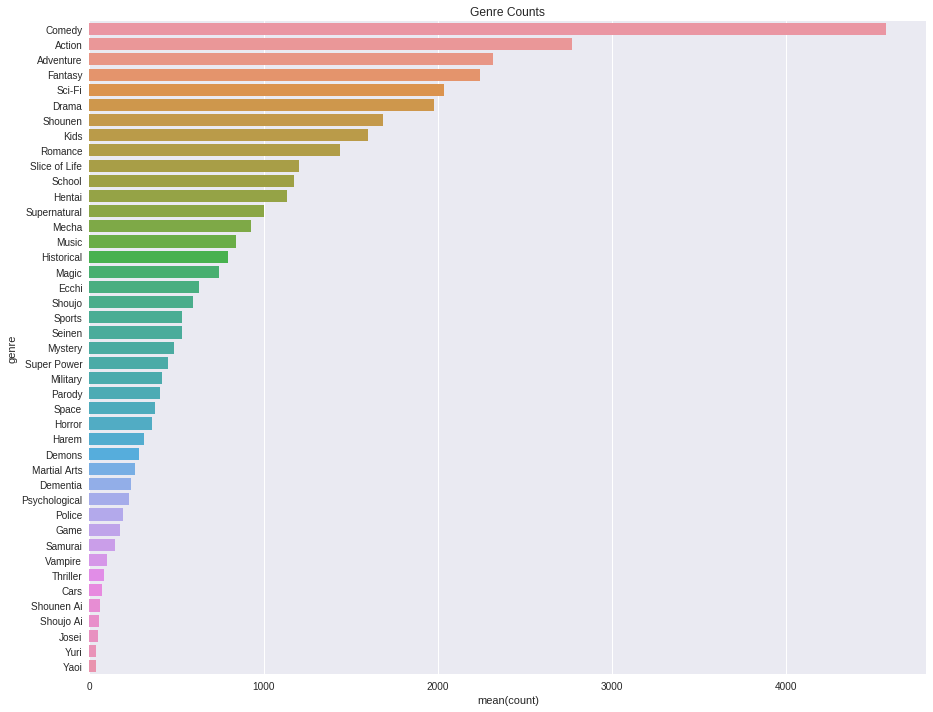

In [19]:
# lets graph this!
fig, ax = plt.subplots(figsize=(15, 12))
result = genre_df.groupby(["genre"])['count'].aggregate(np.median).reset_index().sort_values('count', ascending = False)
sns.barplot(x="count", y="genre", data=genre_df, order = result['genre'], ax = ax).set_title("Genre Counts")
plt.show()

In [20]:
for category in genre: 
    animetable[category] = animetable.genre.apply(lambda x: int(category in x))

animetable = animetable.drop(['genre'], axis = 1)

In [21]:
genreRated = pd.Series()
genreUnrated = pd.Series()
for g in genre:
    genreRated[g] = animetable[animetable[g] == 1].rated.sum()
    genreUnrated[g] = animetable[animetable[g] == 0].unrated.sum()

In [22]:
genreTotal = genreRated + genreUnrated

ratingGenres = pd.DataFrame({'genre': genre, 'unrated':genreUnrated,'rated':genreRated,'total':genreTotal})
ratingGenres.reset_index(drop = True, inplace=True)
ratingGenres.sort_values(by = "total", ascending = False)

,genre,rated,total,unrated
3,Comedy,3150030,3867740,717710
0,Action,2663843,3540758,876915
25,Romance,2031673,3051909,1020236
6,Drama,1727683,2830511,1102828
38,Supernatural,1612457,2737267,1124810
8,Fantasy,1629076,2713281,1084205
27,School,1540798,2673164,1132366
32,Shounen,1514011,2622261,1108250
1,Adventure,1365199,2510898,1145699
28,Sci-Fi,1319449,2502239,1182790


In [23]:
animetable.head()

,anime_id,name,type,episodes,rating,members,unrated,rated,genreCount,Action,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,32281,Kimi no Na wa.,Movie,1,9.37,200630,238,1961,4,0,...,0,0,0,0,0,1,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,TV,64,9.26,793665,3080,21494,7,1,...,0,0,0,0,0,0,0,0,0,0
2,28977,Gintama°,TV,51,9.25,114262,198,1188,7,1,...,0,0,0,0,0,0,0,0,0,0
3,9253,Steins;Gate,TV,24,9.17,673572,2132,17151,2,0,...,0,0,0,0,0,0,1,0,0,0
4,9969,Gintama&#039;,TV,51,9.16,151266,558,3115,7,1,...,0,0,0,0,0,0,0,0,0,0


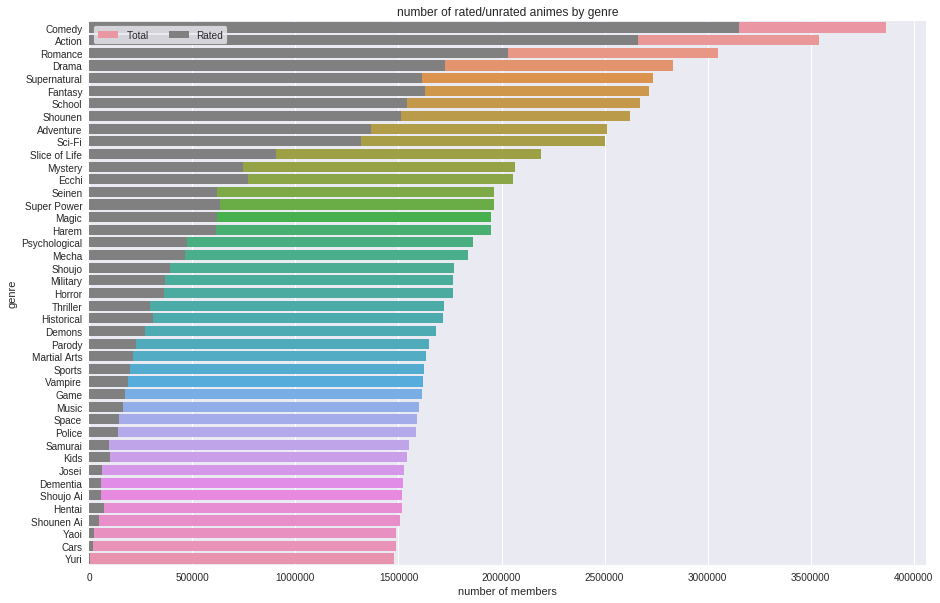

In [24]:
f, ax = plt.subplots(figsize=(15,10))
result = ratingGenres.groupby(["genre"])['total'].aggregate(np.median).reset_index().sort_values('total', ascending = False)
sns.barplot(x="total", y="genre", data=ratingGenres, order = result['genre'], label="Total")
sns.barplot(x="rated", y="genre", data=ratingGenres, order = result['genre'], color = 'gray', label="Rated")

ax.legend(ncol=2, loc="upper left", frameon=True)
ax.set(ylabel="genre",
       xlabel="number of members",
       title = "number of rated/unrated animes by genre")

plt.show()

Members vs Ratings, followed by grouping on genre?

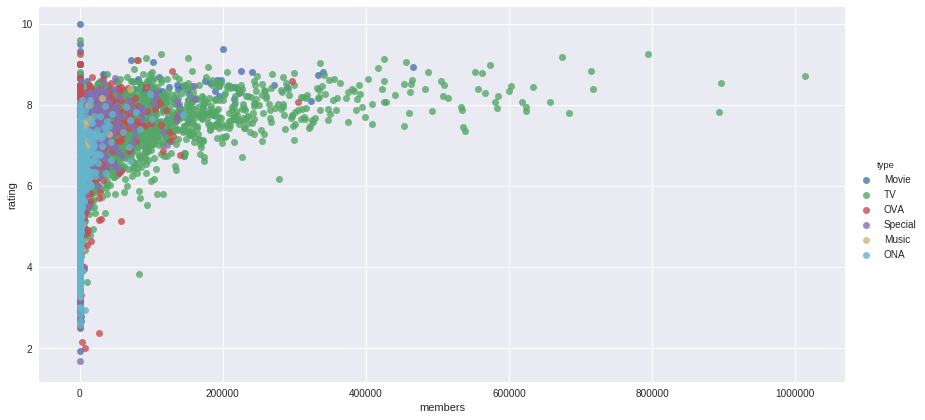

In [25]:
sns.lmplot(y = "rating", x = "members", data=animetable, hue="type", size = 6, aspect = 2, fit_reg=False)

generally the same rating shape for each type, the main difference is the amount of numbers
i mean it makes sense. tv shows tend to have more content so thus more followers?

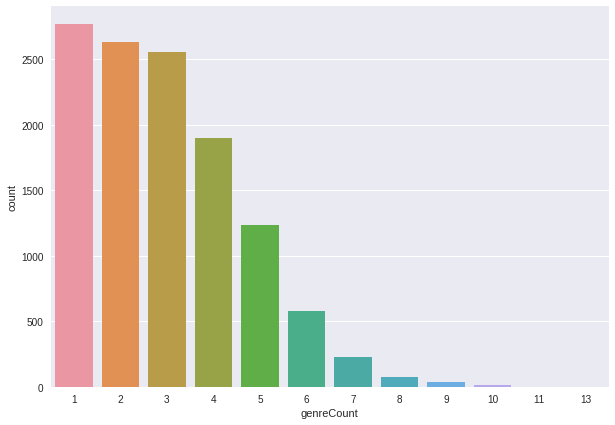

In [31]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x="genreCount", data=animetable, ax = ax)

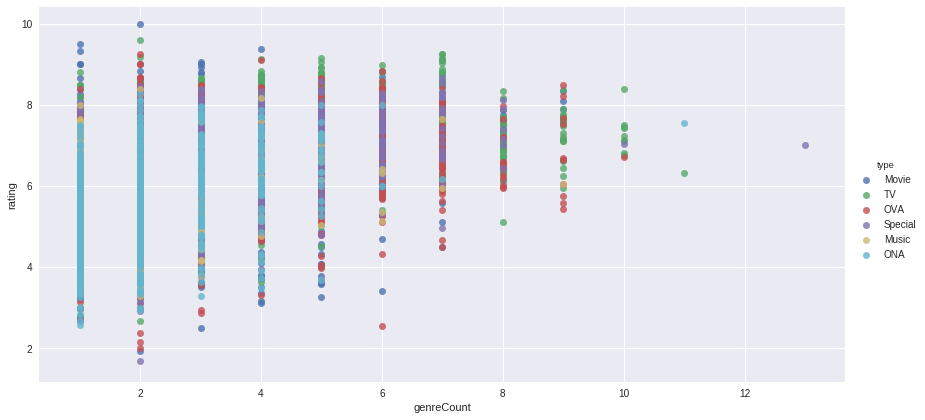

In [32]:
sns.lmplot(x = "genreCount", y = "rating", data=animetable, hue='type', size = 6, aspect = 2, fit_reg=False)

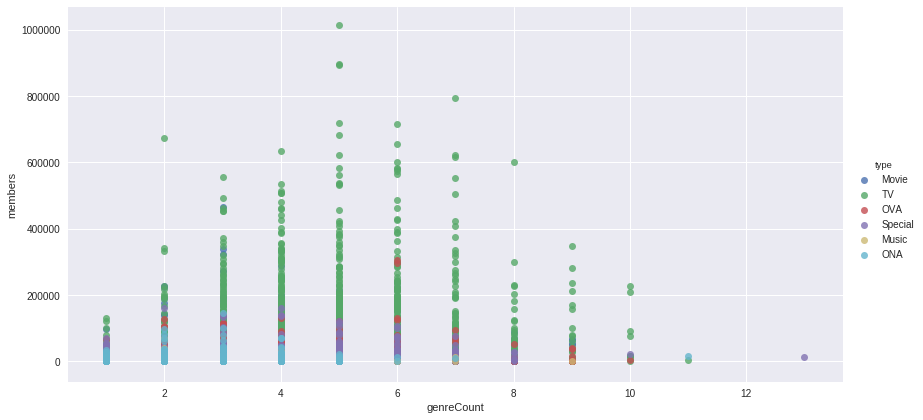

In [33]:
sns.lmplot(x = "genreCount", y = "members", data=animetable, hue='type', size = 6, aspect = 2, fit_reg=False)

ML BELOW MORE OR LESS

In [34]:
# let's figure out if we can somehow classify by popularity, based on number of members
# as a general note, rating also could factor into popularity, but couldn't think of any nice way of 
# weighting such, since there are many low interest, high rating pieces as shown before
animetable['membersRange'] = animetable.members.apply(lambda a: max(0, (int(a) - (int(a) % 50000))))
animetable['membersRangeLog'] = animetable.members.apply(lambda a: int(math.log(a, 10)))

In [35]:
animetable.head()

,anime_id,name,type,episodes,rating,members,unrated,rated,genreCount,Action,...,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,membersRange,membersRangeLog
0,32281,Kimi no Na wa.,Movie,1,9.37,200630,238,1961,4,0,...,0,0,0,1,0,0,0,0,200000,5
1,5114,Fullmetal Alchemist: Brotherhood,TV,64,9.26,793665,3080,21494,7,1,...,0,0,0,0,0,0,0,0,750000,5
2,28977,Gintama°,TV,51,9.25,114262,198,1188,7,1,...,0,0,0,0,0,0,0,0,100000,5
3,9253,Steins;Gate,TV,24,9.17,673572,2132,17151,2,0,...,0,0,0,0,1,0,0,0,650000,5
4,9969,Gintama&#039;,TV,51,9.16,151266,558,3115,7,1,...,0,0,0,0,0,0,0,0,150000,5


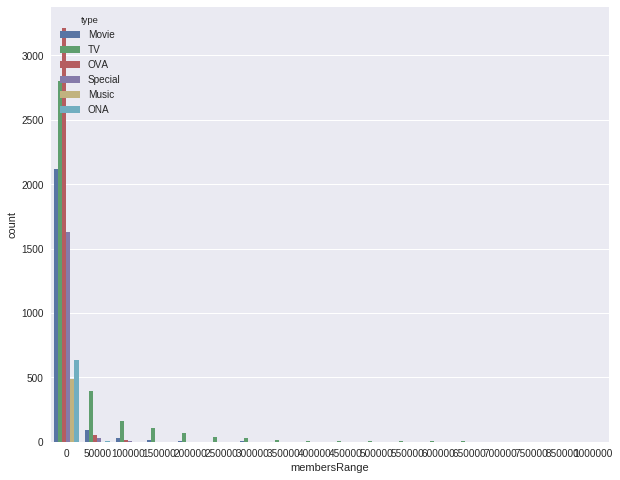

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.countplot(x="membersRange", hue = "type", data=animetable, ax= ax)
#as we can see below, not v useful

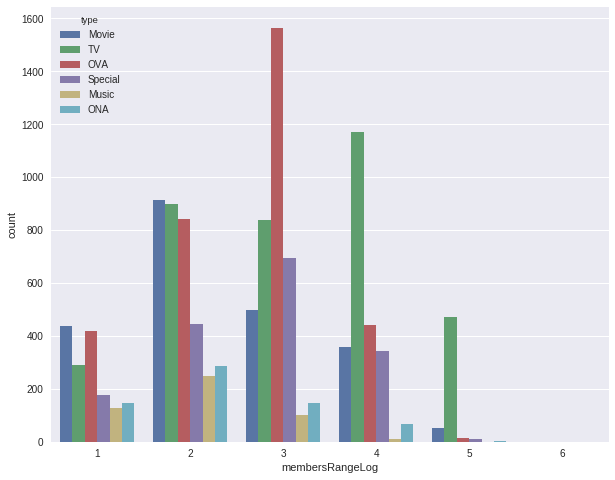

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.countplot(x="membersRangeLog", hue = "type", data=animetable, ax = ax)

In [49]:
print(animetable[animetable['membersRangeLog'] == 3].sample(10).name)
print(animetable[animetable['membersRangeLog'] == 4].sample(10).name)

6378                                            Extra
2586                                     Offside (TV)
3574                                     Youkai Watch
11416                  Ai Shimai 2: Futari no Kajitsu
950                              Go! Princess Precure
5025                                Galaxy Angel Rune
2198     Motto! Ojamajo Doremi: Kaeru Ishi no Himitsu
3463                            Wakakusa no Charlotte
11621                                     Kazama Mana
2721                                 Nintama Rantarou
Name: name, dtype: object
3932                                                Aiura
6894                        Chaos Dragon: Sekiryuu Seneki
2082                                      Love Hina Again
2072    Dragon Ball Z Movie 09: Ginga Girigiri!! Bucch...
465                                   Strike the Blood II
4401                                       Hoshi no Kirby
4560                      Kore ga Watashi no Goshujinsama
550                         

In [50]:
# arbitrary, but let's set anything with more than 10000 members to be 'popular' for classification purposes
animetable['popularClass'] = animetable.membersRangeLog.apply(lambda a: int(a > 3))

In [51]:
animetable.sample(10)

,anime_id,name,type,episodes,rating,members,unrated,rated,genreCount,Action,...,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,membersRange,membersRangeLog,popularClass
2879,475,Hotori: Tada Saiwai wo Koinegau,Movie,1,7.14,3701,21,101,2,0,...,0,0,0,0,0,0,0,0,3,0
3374,4190,Harukanaru Toki no Naka de 3: Kurenai no Tsuki...,Special,1,7.01,1010,9,25,3,0,...,0,0,0,0,0,0,0,0,3,0
392,2924,ef: A Tale of Memories.,TV,12,8.12,151106,797,4983,3,0,...,0,0,0,0,0,0,0,150000,5,1
8817,29537,Hello Kitty no Okaze wo Hiita Santa-san,OVA,1,6.57,59,0,0,2,0,...,0,0,0,0,0,0,0,0,1,0
3341,10213,Maji de Watashi ni Koi Shinasai!,TV,12,7.02,116683,770,3271,7,0,...,0,1,0,0,0,0,0,100000,5,1
4212,17573,Planetarium Uchuu Kyoudai: Itten no Hikari,Movie,1,6.79,2800,14,46,4,0,...,0,0,0,0,0,0,0,0,3,0
1852,5065,Detroit Metal City: Birth of the Metal Devil,Special,1,7.42,16101,229,757,4,0,...,0,0,0,0,0,0,0,0,4,1
10005,13103,Ponta to Ensoku,OVA,1,6.40,185,1,0,2,0,...,0,0,0,0,0,0,0,0,2,0
176,22145,Kuroshitsuji: Book of Circus,TV,10,8.37,122895,849,2695,6,0,...,0,0,1,0,0,0,0,100000,5,1
6032,23409,Duel Masters VS,TV,49,6.27,374,3,2,4,1,...,0,0,0,0,0,0,0,0,2,0


In [52]:
# lets use some classifier to figure out guess if something will be popular or not!

In [54]:
#let's see if we can predict if something will be popular or not with genre, type, and potentially episodes 
# may want to consider if we want episodes or not
#attributes = pd.concat([animetable[genre],animetable[format_type],animetable["episodes"]],axis=1)

#https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/

format_type = [s for s in list(animetable) if "type_" in s]
animetable_type = pd.get_dummies(animetable, columns = ['type'])
attributes = pd.concat([animetable[genre],animetable[format_type]],axis=1)
classification = np.array(animetable['popularClass']) 	# another way of indexing a pandas df

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(attributes, classification, test_size=0.2, random_state=42)

In [55]:
# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)

# fitting the model
knn.fit(X_train, y_train)

# predict the response
pred = knn.predict(X_test)

# evaluate accuracy
print (accuracy_score(y_test, pred))

0.803244592346


In [56]:
#let's try to establish some optimal k without overfitting
accuracy_scores = []

for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k)

    # fitting the model
    knn.fit(X_train, y_train)

    # predict the response
    pred = knn.predict(X_test)

    # evaluate accuracy
    print (accuracy_score(y_test, pred))

0.779950083195
0.799500831947
0.803244592346
0.804492512479
0.810316139767
0.802828618968
0.8115640599
0.799500831947
0.808236272879
0.803244592346
0.80615640599
0.802828618968
0.806572379368
0.805324459235


In [57]:

# creating odd list of K for KNN
myList = list(range(1,15,2))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation <-- why is this necessary?
for k in myList:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

In [58]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = myList[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)

The optimal number of neighbors is 13


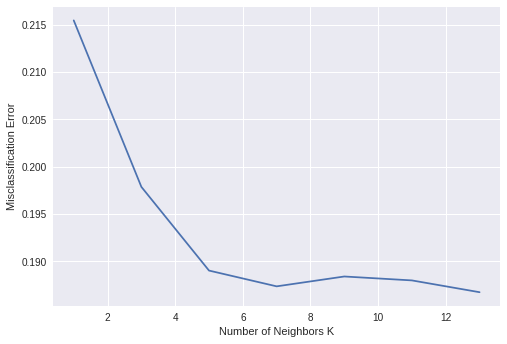

In [59]:
# plot misclassification error vs k
plt.plot(myList, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [60]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)

    # fitting the model
knn.fit(X_train, y_train)

    # predict the response
pred = knn.predict(X_test)

    # evaluate accuracy
print (accuracy_score(y_test, pred))

0.810316139767


now just for fun, what if we want to get anime recommendations?

In [61]:
#let's keep the attributes the same, but we can consider adding elements now
format_type = [s for s in list(animetable) if "type_" in s]
attributes = pd.concat([animetable[genre],animetable[format_type]],axis=1)

#attributes = pd.concat([animetable[genre],animetable[format_type],animetable[["members"]],animetable[["rating"]],
#                        animetable["episodes"]],axis=1)

#nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(attributes)
#distances, indices = nbrs.kneighbors(attributes)
#distance_total = 

In [62]:
def findAnime(name, df):
    list = []
    indices = []
    for index, row in df.iterrows():
        if (name in row['name']):
            list.append(row['name'])
            indices.append(row.name)
    return list, indices
    
animelist, indices = findAnime("Naruto", animetable)
animelist

['Boruto: Naruto the Movie',
 'Naruto: Shippuuden',
 'The Last: Naruto the Movie',
 'Naruto: Shippuuden Movie 6 - Road to Ninja',
 'Naruto',
 'Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi',
 'Naruto: Shippuuden Movie 5 - Blood Prison',
 'Naruto x UT',
 'Naruto: Shippuuden Movie 4 - The Lost Tower',
 'Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono',
 'Naruto: Shippuuden Movie 1',
 'Naruto: Shippuuden Movie 2 - Kizuna',
 'Naruto Shippuuden: Shippuu! &quot;Konoha Gakuen&quot; Den',
 'Naruto: Honoo no Chuunin Shiken! Naruto vs. Konohamaru!!',
 'Naruto SD: Rock Lee no Seishun Full-Power Ninden',
 'Naruto Shippuuden: Sunny Side Battle',
 'Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo!',
 'Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!!',
 'Naruto Movie 2: Dai Gekitotsu! Maboroshi no Chiteiiseki Dattebayo!',
 'Naruto: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo! Special: Konoha Annual Sports Festival',
 'Naruto Movie 3: D

In [63]:
def findSimilar(index, df, attributes, neighbors = 2):
    list = []
    tree = BallTree(attributes, leaf_size=2)              
    dist, ind = tree.query([attributes.iloc[index]], k = neighbors)
    for i in ind.flatten():
        list.append(animetable.iloc[i]['name'])
    return list

findSimilar(indices[1], animetable, attributes, 10) # well it makes sense they are all naruto lmao

['Naruto x UT',
 'Naruto: Shippuuden Movie 4 - The Lost Tower',
 'Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!!',
 'Naruto Shippuuden: Sunny Side Battle',
 'Naruto: Shippuuden',
 'Boruto: Naruto the Movie',
 'Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi',
 'Naruto',
 'Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono',
 'Battle Spirits: Ryuuko no Ken']